# 🌬️ AIR GUARD – Phần 2: Semi-Supervised Learning
## Self-Training & Co-Training cho Cảnh báo AQI

---

### 📚 Tiếp nối từ Notebook 1

Trong notebook trước, chúng ta đã:
- ✅ Khám phá và tiền xử lý dữ liệu Beijing Air Quality
- ✅ Gắn nhãn AQI (6 mức độ) từ PM2.5
- ✅ Tạo tập Labeled (5%) và Unlabeled (95%)
- ✅ Feature Engineering
- ✅ Huấn luyện Supervised Baseline

**Kết quả Baseline**: Accuracy ~65-70%, F1 Macro ~0.40-0.50

### 🎯 Mục tiêu notebook này

1. **Self-Training**: Mô hình tự gán nhãn giả cho dữ liệu unlabeled
2. **Co-Training**: Hai mô hình hợp tác, trao đổi nhãn giả
3. **So sánh**: Baseline vs Self-Training vs Co-Training

---

## 🔧 Setup và Load dữ liệu

In [8]:
# ============================================================
# Import thư viện
# ============================================================

import sys
from pathlib import Path

PROJECT_ROOT = Path('.').resolve()
if not (PROJECT_ROOT / 'data').exists() and (PROJECT_ROOT.parent / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay
)

# Cấu hình hiển thị
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Import thư viện dự án
from src.classification_library import AQI_CLASSES, time_split

print("✅ Import thành công!")
print(f"📁 Project root: {PROJECT_ROOT}")

✅ Import thành công!
📁 Project root: D:\BaiTap\Nam3\KI2\Data_Mining\Tuan8\air_guard


In [9]:
# ============================================================
# Load dữ liệu đã xử lý từ notebook trước
# ============================================================

DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'dataset_semi_supervised.parquet'

if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)
    print(f"✅ Đã load dữ liệu: {DATA_PATH}")
    print(f"   - Số dòng: {len(df):,}")
    print(f"   - Số cột: {len(df.columns)}")
else:
    print("❌ Chưa có file dữ liệu. Vui lòng chạy notebook 1 trước!")
    print(f"   Đường dẫn mong đợi: {DATA_PATH}")

✅ Đã load dữ liệu: D:\BaiTap\Nam3\KI2\Data_Mining\Tuan8\air_guard\data\processed\dataset_semi_supervised.parquet
   - Số dòng: 420,768
   - Số cột: 100


In [10]:
# ============================================================
# Cấu hình
# ============================================================

CUTOFF_DATE = "2017-01-01"
RANDOM_STATE = 42
VAL_FRACTION = 0.2

# Các cột không dùng làm feature (bao gồm categorical)
EXCLUDE_COLS = {
    'PM2.5', 'pm25_24h', 'aqi_class', 'aqi_class_original',
    'datetime', 'is_labeled',
    'station',  # Categorical - tên trạm
    'wd',       # Categorical - hướng gió (wind direction: N, S, E, W, NE, SW, WSW, etc.)
}

# Lấy feature columns (loại bỏ excluded)
feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS]

# Chỉ giữ các cột numeric
feature_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"📌 Số features: {len(feature_cols)}")
print(f"   Ví dụ: {feature_cols[:5]}...")

📌 Số features: 92
   Ví dụ: ['No', 'year', 'month', 'day', 'hour']...


In [11]:
# ============================================================
# Chuẩn bị các tập dữ liệu
# ============================================================

cutoff_ts = pd.Timestamp(CUTOFF_DATE)

# Masks
train_mask = df['datetime'] < cutoff_ts
test_mask = df['datetime'] >= cutoff_ts
train_labeled_mask = train_mask & df['is_labeled']
train_unlabeled_mask = train_mask & ~df['is_labeled']

# Labeled train
X_train_labeled = df.loc[train_labeled_mask, feature_cols].copy()
y_train_labeled = df.loc[train_labeled_mask, 'aqi_class'].copy()

# Unlabeled pool
X_unlabeled = df.loc[train_unlabeled_mask, feature_cols].copy()
y_unlabeled_true = df.loc[train_unlabeled_mask, 'aqi_class_original'].copy()  # Ground truth để đánh giá

# Test set
test_with_labels = test_mask & df['aqi_class_original'].notna()
X_test = df.loc[test_with_labels, feature_cols].copy()
y_test = df.loc[test_with_labels, 'aqi_class_original'].copy()

# Chia validation từ labeled
X_train, X_val, y_train, y_val = train_test_split(
    X_train_labeled, y_train_labeled,
    test_size=VAL_FRACTION,
    random_state=RANDOM_STATE,
    stratify=y_train_labeled
)

print("📊 KÍCH THƯỚC DỮ LIỆU:")
print(f"   - Train (labeled): {X_train.shape}")
print(f"   - Validation: {X_val.shape}")
print(f"   - Unlabeled pool: {X_unlabeled.shape}")
print(f"   - Test: {X_test.shape}")

📊 KÍCH THƯỚC DỮ LIỆU:
   - Train (labeled): (15852, 92)
   - Validation: (3964, 92)
   - Unlabeled pool: (383960, 92)
   - Test: (16671, 92)


# ═══════════════════════════════════════════════════════════════
# PHẦN 6: SELF-TRAINING
# ═══════════════════════════════════════════════════════════════

## 📖 Lý thuyết: Self-Training là gì?

**Self-Training** (hay Pseudo-Labeling) là phương pháp semi-supervised đơn giản nhất:

### Ý tưởng cốt lõi:
> "Mô hình tự tin vào dự đoán của mình → sử dụng dự đoán đó như nhãn thật"

### Thuật toán từng bước:

```
1. Khởi tạo: Huấn luyện mô hình M trên tập labeled L
2. Lặp lại (max_iter lần):
   a. Dùng M dự đoán probability cho tập unlabeled U
   b. Chọn các mẫu có confidence >= τ (threshold)
   c. Gán pseudo-label cho các mẫu được chọn
   d. Thêm vào tập labeled L
   e. Huấn luyện lại M trên L mở rộng
   f. Dừng nếu không có mẫu mới (< min_new_per_iter)
3. Trả về: Mô hình M đã được cải thiện
```

### Các tham số quan trọng:

| Tham số | Ý nghĩa | Giá trị thường dùng |
|---------|---------|--------------------|
| τ (tau) | Confidence threshold | 0.85 - 0.95 |
| max_iter | Số vòng lặp tối đa | 5 - 20 |
| min_new_per_iter | Số mẫu tối thiểu thêm mỗi vòng | 10 - 50 |

### Ưu & Nhược điểm:

**Ưu điểm:**
- ✅ Đơn giản, dễ implement
- ✅ Hoạt động với bất kỳ classifier nào có predict_proba
- ✅ Không cần giả định về cấu trúc dữ liệu

**Nhược điểm:**
- ❌ Error propagation: Sai lầm ban đầu có thể lan truyền
- ❌ Confirmation bias: Mô hình "tự tin" sai
- ❌ Không tận dụng được structure của unlabeled data

In [12]:
# ============================================================
# CẤU HÌNH SELF-TRAINING
# ============================================================

SELF_TRAINING_CONFIG = {
    'tau': 0.90,              # Confidence threshold
    'max_iter': 10,           # Số vòng lặp tối đa
    'min_new_per_iter': 20,   # Dừng nếu thêm ít hơn 20 mẫu
}

print("📌 CẤU HÌNH SELF-TRAINING:")
for key, value in SELF_TRAINING_CONFIG.items():
    print(f"   - {key}: {value}")

📌 CẤU HÌNH SELF-TRAINING:
   - tau: 0.9
   - max_iter: 10
   - min_new_per_iter: 20


In [13]:
# ============================================================
# Implement Self-Training từ đầu (để hiểu rõ thuật toán)
# ============================================================

class SelfTrainingClassifier:
    """
    Self-Training Classifier implementation cho mục đích giáo dục.
    
    Mô tả thuật toán:
    -----------------
    Self-training là một wrapper algorithm biến bất kỳ classifier nào
    có method predict_proba() thành semi-supervised learner.
    
    Tại mỗi iteration:
    1. Train classifier trên labeled data hiện tại
    2. Predict probabilities cho unlabeled data
    3. Chọn samples có confidence cao (>= tau)
    4. Gán pseudo-labels và thêm vào labeled set
    5. Lặp lại cho đến khi hội tụ
    """
    
    def __init__(self, base_classifier, tau=0.9, max_iter=10, 
                 min_new_per_iter=20, random_state=42):
        self.base_classifier = base_classifier
        self.tau = tau
        self.max_iter = max_iter
        self.min_new_per_iter = min_new_per_iter
        self.random_state = random_state
        
        # Tracking
        self.history_ = []
        self.model_ = None
        
    def fit(self, X_labeled, y_labeled, X_unlabeled, X_val=None, y_val=None):
        """
        Huấn luyện Self-Training.
        
        Parameters:
        -----------
        X_labeled : Dữ liệu có nhãn
        y_labeled : Nhãn tương ứng
        X_unlabeled : Dữ liệu không nhãn (pool)
        X_val, y_val : Validation set (optional, để tracking)
        """
        # Copy để không modify original
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        X_pool = X_unlabeled.copy()
        pool_indices = np.arange(len(X_pool))
        
        print(f"\n{'='*60}")
        print("🚀 BẮT ĐẦU SELF-TRAINING")
        print(f"{'='*60}")
        print(f"   - Labeled ban đầu: {len(X_train):,}")
        print(f"   - Unlabeled pool: {len(X_pool):,}")
        print(f"   - Threshold τ: {self.tau}")
        print(f"{'='*60}\n")
        
        for iteration in range(1, self.max_iter + 1):
            # Step 1: Train trên labeled hiện tại
            self.base_classifier.fit(X_train, y_train)
            
            # Step 2: Đánh giá trên validation (nếu có)
            val_acc = val_f1 = None
            if X_val is not None and y_val is not None:
                y_val_pred = self.base_classifier.predict(X_val)
                val_acc = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
            
            # Step 3: Predict probabilities cho unlabeled pool
            if len(pool_indices) == 0:
                print(f"   Vòng {iteration}: Pool đã hết! Dừng.")
                break
                
            X_pool_current = X_pool.iloc[pool_indices]
            proba = self.base_classifier.predict_proba(X_pool_current)
            max_proba = proba.max(axis=1)
            y_pseudo = self.base_classifier.classes_[proba.argmax(axis=1)]
            
            # Step 4: Chọn samples có confidence >= tau
            confident_mask = max_proba >= self.tau
            n_confident = confident_mask.sum()
            
            # Lưu history
            self.history_.append({
                'iteration': iteration,
                'labeled_size': len(X_train),
                'unlabeled_pool': len(pool_indices),
                'new_pseudo': int(n_confident),
                'val_accuracy': val_acc,
                'val_f1_macro': val_f1,
                'mean_confidence': float(max_proba[confident_mask].mean()) if n_confident > 0 else 0,
            })
            
            print(f"   Vòng {iteration}: "
                  f"Labeled={len(X_train):,}, "
                  f"Pool={len(pool_indices):,}, "
                  f"New={n_confident:,}, "
                  f"Val_Acc={val_acc:.4f}" if val_acc else "")
            
            # Step 5: Kiểm tra điều kiện dừng
            if n_confident < self.min_new_per_iter:
                print(f"   → Dừng: Chỉ có {n_confident} mẫu mới (< {self.min_new_per_iter})")
                break
            
            # Step 6: Thêm pseudo-labeled samples vào training set
            confident_indices = np.where(confident_mask)[0]
            X_new = X_pool_current.iloc[confident_indices]
            y_new = y_pseudo[confident_indices]
            
            X_train = pd.concat([X_train, X_new], ignore_index=True)
            y_train = pd.concat([y_train, pd.Series(y_new)], ignore_index=True)
            
            # Cập nhật pool (loại bỏ samples đã được chọn)
            remaining_mask = ~confident_mask
            pool_indices = pool_indices[remaining_mask]
        
        # Final fit
        self.base_classifier.fit(X_train, y_train)
        self.model_ = self.base_classifier
        
        print(f"\n{'='*60}")
        print("✅ SELF-TRAINING HOÀN TẤT!")
        print(f"   - Labeled cuối cùng: {len(X_train):,}")
        print(f"   - Unlabeled còn lại: {len(pool_indices):,}")
        print(f"{'='*60}")
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

print("✅ Đã định nghĩa class SelfTrainingClassifier")

✅ Đã định nghĩa class SelfTrainingClassifier


In [14]:
# ============================================================
# Huấn luyện Self-Training
# ============================================================

# Base classifier
base_clf = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.08,
    max_iter=250,
    random_state=RANDOM_STATE
)

# Self-Training wrapper
self_trainer = SelfTrainingClassifier(
    base_classifier=base_clf,
    tau=SELF_TRAINING_CONFIG['tau'],
    max_iter=SELF_TRAINING_CONFIG['max_iter'],
    min_new_per_iter=SELF_TRAINING_CONFIG['min_new_per_iter'],
    random_state=RANDOM_STATE
)

# Fit
self_trainer.fit(
    X_labeled=X_train,
    y_labeled=y_train,
    X_unlabeled=X_unlabeled,
    X_val=X_val,
    y_val=y_val
)


🚀 BẮT ĐẦU SELF-TRAINING
   - Labeled ban đầu: 15,852
   - Unlabeled pool: 383,960
   - Threshold τ: 0.9

   Vòng 1: Labeled=15,852, Pool=383,960, New=204,764, Val_Acc=0.8317
   Vòng 2: Labeled=220,616, Pool=179,196, New=96,505, Val_Acc=0.8186
   Vòng 3: Labeled=317,121, Pool=82,691, New=15,433, Val_Acc=0.7919
   Vòng 4: Labeled=332,554, Pool=67,258, New=5,100, Val_Acc=0.7846
   Vòng 5: Labeled=337,654, Pool=62,158, New=3,329, Val_Acc=0.7881
   Vòng 6: Labeled=340,983, Pool=58,829, New=1,995, Val_Acc=0.7878
   Vòng 7: Labeled=342,978, Pool=56,834, New=2,051, Val_Acc=0.7929
   Vòng 8: Labeled=345,029, Pool=54,783, New=1,392, Val_Acc=0.7858
   Vòng 9: Labeled=346,421, Pool=53,391, New=1,610, Val_Acc=0.7896
   Vòng 10: Labeled=348,031, Pool=51,781, New=955, Val_Acc=0.7823

✅ SELF-TRAINING HOÀN TẤT!
   - Labeled cuối cùng: 348,986
   - Unlabeled còn lại: 50,826


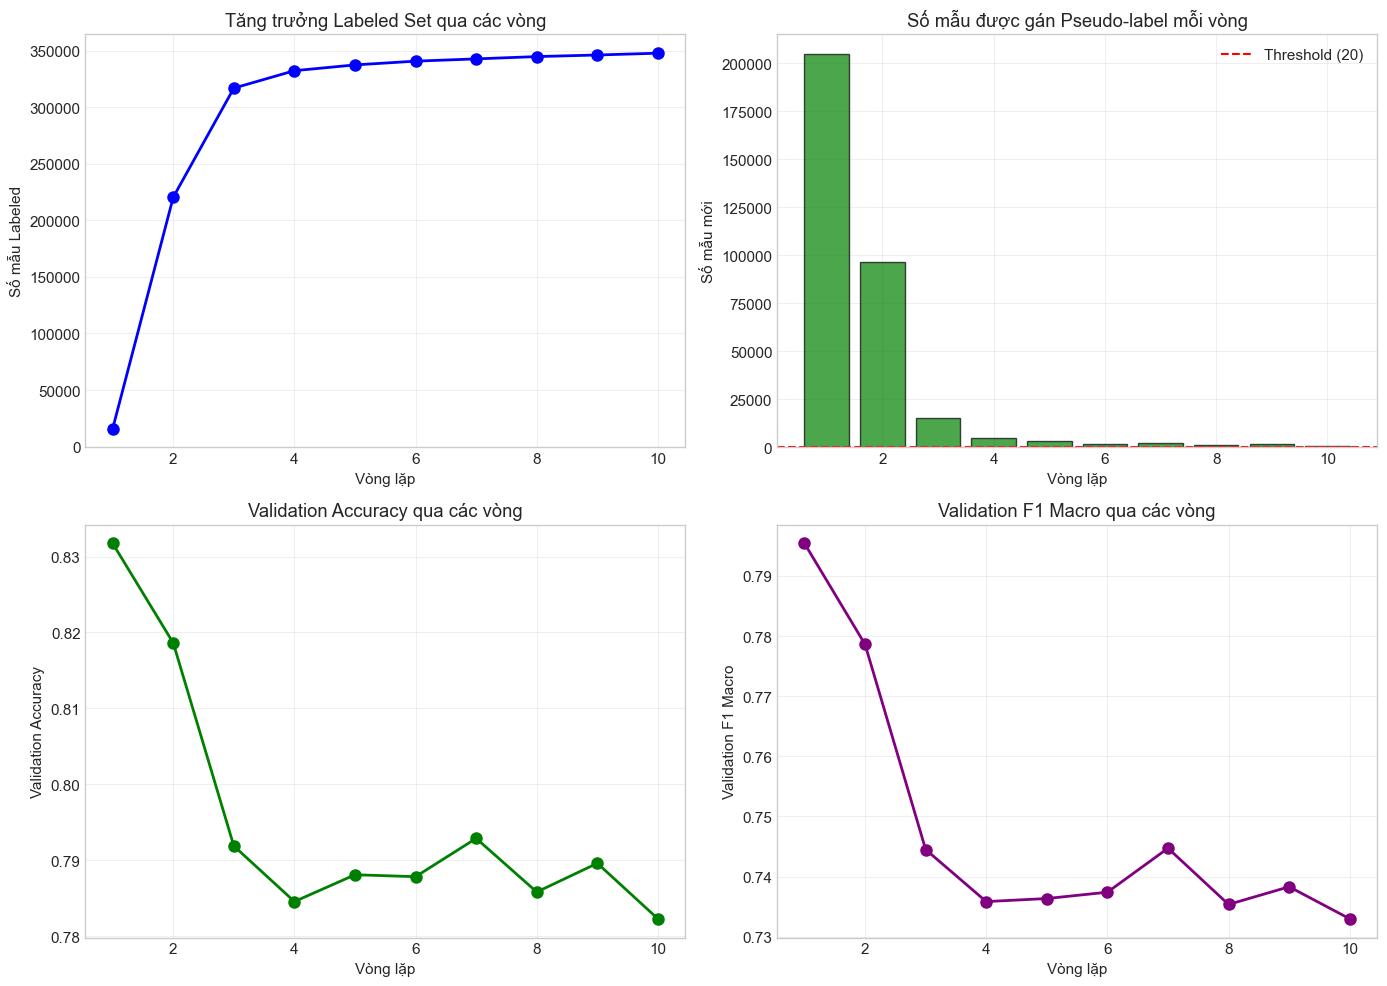


📊 BẢNG THEO DÕI CHI TIẾT:


,iteration,labeled_size,unlabeled_pool,new_pseudo,val_accuracy,val_f1_macro,mean_confidence
0,1,15852,383960,204764,0.831736,0.795420,0.969483
1,2,220616,179196,96505,0.818618,0.778619,0.969263
2,3,317121,82691,15433,0.791877,0.744502,0.942112
3,4,332554,67258,5100,0.784561,0.735846,0.924171
4,5,337654,62158,3329,0.788093,0.736357,0.920859
5,6,340983,58829,1995,0.787841,0.737409,0.918761
6,7,342978,56834,2051,0.792886,0.744724,0.922766
7,8,345029,54783,1392,0.785822,0.735370,0.920800
8,9,346421,53391,1610,0.789606,0.738314,0.925026
9,10,348031,51781,955,0.782291,0.732983,0.921073


In [15]:
# ============================================================
# Trực quan hóa quá trình Self-Training
# ============================================================

history_df = pd.DataFrame(self_trainer.history_)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Số mẫu labeled qua các vòng
ax1 = axes[0, 0]
ax1.plot(history_df['iteration'], history_df['labeled_size'], 'b-o', linewidth=2, markersize=8)
ax1.set_xlabel('Vòng lặp')
ax1.set_ylabel('Số mẫu Labeled')
ax1.set_title('Tăng trưởng Labeled Set qua các vòng')
ax1.grid(True, alpha=0.3)

# Plot 2: Số mẫu mới mỗi vòng
ax2 = axes[0, 1]
ax2.bar(history_df['iteration'], history_df['new_pseudo'], color='green', alpha=0.7, edgecolor='black')
ax2.axhline(y=SELF_TRAINING_CONFIG['min_new_per_iter'], color='red', linestyle='--', 
            label=f'Threshold ({SELF_TRAINING_CONFIG["min_new_per_iter"]})')
ax2.set_xlabel('Vòng lặp')
ax2.set_ylabel('Số mẫu mới')
ax2.set_title('Số mẫu được gán Pseudo-label mỗi vòng')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy
ax3 = axes[1, 0]
if history_df['val_accuracy'].notna().any():
    ax3.plot(history_df['iteration'], history_df['val_accuracy'], 'g-o', linewidth=2, markersize=8)
    ax3.set_xlabel('Vòng lặp')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_title('Validation Accuracy qua các vòng')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Không có validation data', ha='center', va='center')

# Plot 4: Validation F1 Macro
ax4 = axes[1, 1]
if history_df['val_f1_macro'].notna().any():
    ax4.plot(history_df['iteration'], history_df['val_f1_macro'], 'purple', marker='o', linewidth=2, markersize=8)
    ax4.set_xlabel('Vòng lặp')
    ax4.set_ylabel('Validation F1 Macro')
    ax4.set_title('Validation F1 Macro qua các vòng')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Không có validation data', ha='center', va='center')

plt.tight_layout()
plt.show()

print("\n📊 BẢNG THEO DÕI CHI TIẾT:")
display(history_df)

In [16]:
# ============================================================
# Đánh giá Self-Training trên Test Set
# ============================================================

y_test_pred_st = self_trainer.predict(X_test)

st_accuracy = accuracy_score(y_test, y_test_pred_st)
st_f1_macro = f1_score(y_test, y_test_pred_st, average='macro', zero_division=0)
st_f1_weighted = f1_score(y_test, y_test_pred_st, average='weighted', zero_division=0)

SELF_TRAINING_RESULTS = {
    'model': 'Self-Training',
    'test_accuracy': st_accuracy,
    'test_f1_macro': st_f1_macro,
    'test_f1_weighted': st_f1_weighted,
}

print("📊 KẾT QUẢ SELF-TRAINING TRÊN TEST SET:")
print("="*50)
print(f"   - Accuracy:    {st_accuracy:.4f} ({st_accuracy*100:.2f}%)")
print(f"   - F1 Macro:    {st_f1_macro:.4f}")
print(f"   - F1 Weighted: {st_f1_weighted:.4f}")

📊 KẾT QUẢ SELF-TRAINING TRÊN TEST SET:
   - Accuracy:    0.8012 (80.12%)
   - F1 Macro:    0.7377
   - F1 Weighted: 0.7872


In [17]:
# ============================================================
# Classification Report Self-Training
# ============================================================

print("📊 CLASSIFICATION REPORT - SELF-TRAINING:")
print("="*70)
print(classification_report(y_test, y_test_pred_st, target_names=AQI_CLASSES, zero_division=0))

📊 CLASSIFICATION REPORT - SELF-TRAINING:
                                precision    recall  f1-score   support

                          Good       0.74      0.32      0.45      1032
                      Moderate       0.92      0.88      0.90      1855
Unhealthy_for_Sensitive_Groups       0.76      0.93      0.84      4833
                     Unhealthy       0.81      0.91      0.86      4286
                Very_Unhealthy       0.70      0.44      0.54      2166
                     Hazardous       0.88      0.82      0.84      2499

                      accuracy                           0.80     16671
                     macro avg       0.80      0.72      0.74     16671
                  weighted avg       0.80      0.80      0.79     16671



In [18]:
# ============================================================
# Huấn luyện lại Baseline để so sánh (cùng điều kiện)
# ============================================================

baseline_model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.08,
    max_iter=250,
    random_state=RANDOM_STATE
)
baseline_model.fit(X_train, y_train)
y_test_pred_baseline = baseline_model.predict(X_test)

baseline_accuracy = accuracy_score(y_test, y_test_pred_baseline)
baseline_f1_macro = f1_score(y_test, y_test_pred_baseline, average='macro', zero_division=0)
baseline_f1_weighted = f1_score(y_test, y_test_pred_baseline, average='weighted', zero_division=0)

BASELINE_RESULTS = {
    'model': 'Supervised Baseline',
    'test_accuracy': baseline_accuracy,
    'test_f1_macro': baseline_f1_macro,
    'test_f1_weighted': baseline_f1_weighted,
}

print("📊 KẾT QUẢ BASELINE TRÊN TEST SET:")
print("="*50)
print(f"   - Accuracy:    {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"   - F1 Macro:    {baseline_f1_macro:.4f}")
print(f"   - F1 Weighted: {baseline_f1_weighted:.4f}")

📊 KẾT QUẢ BASELINE TRÊN TEST SET:
   - Accuracy:    0.8066 (80.66%)
   - F1 Macro:    0.7277
   - F1 Weighted: 0.7890


In [19]:
# ============================================================
# So sánh Baseline vs Self-Training
# ============================================================

print("📊 SO SÁNH: BASELINE vs SELF-TRAINING")
print("="*70)
print(f"\n{'Metric':<20} {'Baseline':>15} {'Self-Training':>15} {'Thay đổi':>15}")
print("-"*70)

metrics = [
    ('Accuracy', baseline_accuracy, st_accuracy),
    ('F1 Macro', baseline_f1_macro, st_f1_macro),
    ('F1 Weighted', baseline_f1_weighted, st_f1_weighted),
]

for name, base, st in metrics:
    change = st - base
    change_str = f"+{change:.4f}" if change >= 0 else f"{change:.4f}"
    emoji = "📈" if change > 0 else "📉" if change < 0 else "➡️"
    print(f"{name:<20} {base:>15.4f} {st:>15.4f} {change_str:>12} {emoji}")

print("\n" + "="*70)

print("\n💡 NHẬN XÉT:")
if st_f1_macro > baseline_f1_macro:
    print("   ✅ Self-Training CẢI THIỆN so với Baseline!")
    print(f"   - F1 Macro tăng: {(st_f1_macro - baseline_f1_macro)*100:.2f}%")
    print("   - Mô hình đã học được từ dữ liệu unlabeled")
else:
    print("   ⚠️ Self-Training KHÔNG cải thiện đáng kể")
    print("   - Có thể do error propagation (nhãn giả sai lan truyền)")
    print("   - Hoặc threshold τ chưa phù hợp")

📊 SO SÁNH: BASELINE vs SELF-TRAINING

Metric                      Baseline   Self-Training        Thay đổi
----------------------------------------------------------------------
Accuracy                      0.8066          0.8012      -0.0053 📉
F1 Macro                      0.7277          0.7377      +0.0101 📈
F1 Weighted                   0.7890          0.7872      -0.0018 📉


💡 NHẬN XÉT:
   ✅ Self-Training CẢI THIỆN so với Baseline!
   - F1 Macro tăng: 1.01%
   - Mô hình đã học được từ dữ liệu unlabeled


In [20]:
# ============================================================
# Phân tích theo từng lớp AQI
# ============================================================

f1_baseline_per_class = f1_score(y_test, y_test_pred_baseline, labels=AQI_CLASSES, average=None, zero_division=0)
f1_st_per_class = f1_score(y_test, y_test_pred_st, labels=AQI_CLASSES, average=None, zero_division=0)

print("📊 F1-SCORE THEO TỪNG LỚP AQI:")
print("="*70)
print(f"\n{'Lớp AQI':<35} {'Baseline':>10} {'Self-Train':>12} {'Δ':>10}")
print("-"*70)

improved_classes = []
degraded_classes = []

for aqi_class, f1_base, f1_st in zip(AQI_CLASSES, f1_baseline_per_class, f1_st_per_class):
    change = f1_st - f1_base
    if change > 0.01:
        improved_classes.append(aqi_class)
        emoji = "📈"
    elif change < -0.01:
        degraded_classes.append(aqi_class)
        emoji = "📉"
    else:
        emoji = "➡️"
    print(f"{aqi_class:<35} {f1_base:>10.4f} {f1_st:>12.4f} {change:>+10.4f} {emoji}")

print("\n" + "="*70)
print(f"\n🎯 Lớp được cải thiện: {improved_classes}")
print(f"⚠️ Lớp bị giảm: {degraded_classes}")

📊 F1-SCORE THEO TỪNG LỚP AQI:

Lớp AQI                               Baseline   Self-Train          Δ
----------------------------------------------------------------------
Good                                    0.3390       0.4518    +0.1128 📈
Moderate                                0.8407       0.8358    -0.0049 ➡️
Unhealthy_for_Sensitive_Groups          0.5680       0.5377    -0.0303 📉
Unhealthy                               0.8670       0.8571    -0.0099 ➡️
Very_Unhealthy                          0.8465       0.8449    -0.0016 ➡️
Hazardous                               0.9048       0.8991    -0.0057 ➡️


🎯 Lớp được cải thiện: ['Good']
⚠️ Lớp bị giảm: ['Unhealthy_for_Sensitive_Groups']


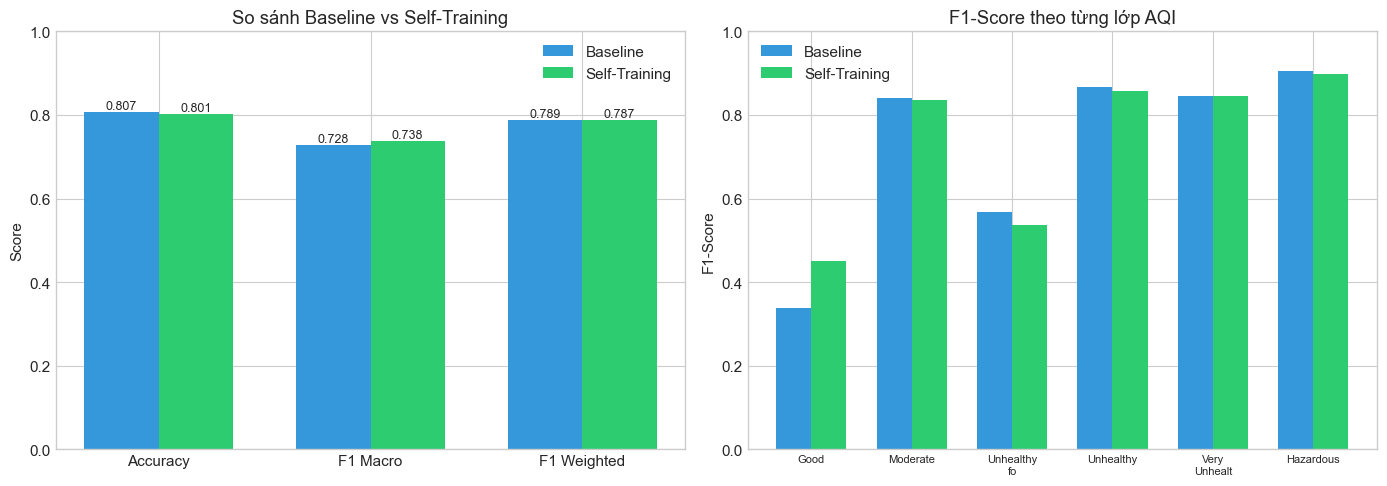

In [21]:
# ============================================================
# Trực quan hóa so sánh
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart so sánh metrics
ax1 = axes[0]
x = np.arange(3)
width = 0.35

metrics_names = ['Accuracy', 'F1 Macro', 'F1 Weighted']
baseline_vals = [baseline_accuracy, baseline_f1_macro, baseline_f1_weighted]
st_vals = [st_accuracy, st_f1_macro, st_f1_weighted]

bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline', color='#3498db')
bars2 = ax1.bar(x + width/2, st_vals, width, label='Self-Training', color='#2ecc71')

ax1.set_ylabel('Score')
ax1.set_title('So sánh Baseline vs Self-Training')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.set_ylim(0, 1)

# Thêm giá trị trên bar
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)

# Plot 2: F1 per class
ax2 = axes[1]
x = np.arange(len(AQI_CLASSES))

bars1 = ax2.bar(x - width/2, f1_baseline_per_class, width, label='Baseline', color='#3498db')
bars2 = ax2.bar(x + width/2, f1_st_per_class, width, label='Self-Training', color='#2ecc71')

ax2.set_ylabel('F1-Score')
ax2.set_title('F1-Score theo từng lớp AQI')
ax2.set_xticks(x)
ax2.set_xticklabels([c.replace('_', '\n')[:12] for c in AQI_CLASSES], rotation=0, fontsize=8)
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 📝 Tổng kết Self-Training

### ✅ Kết quả:
- Self-Training có thể cải thiện hiệu suất khi threshold τ được chọn phù hợp
- Số mẫu được gán pseudo-label phụ thuộc vào độ tự tin của mô hình

### 📌 Lessons Learned:
1. **Threshold τ quan trọng**: τ cao → ít mẫu nhưng chất lượng; τ thấp → nhiều mẫu nhưng rủi ro sai
2. **Error propagation**: Nếu vòng đầu sai nhiều, các vòng sau sẽ học sai
3. **Class imbalance**: Các lớp thiểu số khó được cải thiện

### ➡️ Bước tiếp theo: Co-Training

# ═══════════════════════════════════════════════════════════════
# PHẦN 7: CO-TRAINING
# ═══════════════════════════════════════════════════════════════

## 📖 Lý thuyết: Co-Training là gì?

**Co-Training** (Blum & Mitchell, 1998) là phương pháp semi-supervised sử dụng **2 mô hình** huấn luyện đồng thời trên **2 view** khác nhau của dữ liệu.

### Ý tưởng cốt lõi:
> "Hai người thầy dạy lẫn nhau - mỗi người nhìn vấn đề từ góc độ khác"

### Giả định (Assumptions):

1. **Sufficiency**: Mỗi view đủ để phân loại đúng
2. **Conditional Independence**: Hai view độc lập cho trước nhãn

### Thuật toán:

```
1. Chia features thành 2 view: V1 và V2
2. Huấn luyện 2 mô hình: M1 (trên V1) và M2 (trên V2)
3. Lặp lại:
   a. M1 dự đoán unlabeled → chọn mẫu confident
   b. M2 dự đoán unlabeled → chọn mẫu confident
   c. M1 gửi pseudo-labels cho M2 (và ngược lại)
   d. Cả hai huấn luyện lại với dữ liệu mới
4. Kết hợp: Ensemble M1 + M2 để predict
```

### Trong AIR GUARD:

- **View 1 (Temporal)**: Hour, day, month, lag features → Pattern thời gian
- **View 2 (Environmental)**: Temperature, pressure, wind, weather → Điều kiện môi trường

### Ưu & Nhược điểm:

**Ưu điểm:**
- ✅ Hai mô hình kiểm tra chéo lẫn nhau
- ✅ Ít bị error propagation hơn self-training
- ✅ Tận dụng được các góc nhìn khác nhau

**Nhược điểm:**
- ❌ Yêu cầu 2 view độc lập (khó đảm bảo trong thực tế)
- ❌ Phức tạp hơn để implement
- ❌ Nếu view không độc lập → có thể không hiệu quả

In [22]:
# ============================================================
# CẤU HÌNH CO-TRAINING
# ============================================================

CO_TRAINING_CONFIG = {
    'tau': 0.90,              # Confidence threshold
    'max_iter': 10,           # Số vòng lặp tối đa
    'max_new_per_iter': 500,  # Giới hạn mẫu mới mỗi vòng
    'min_new_per_iter': 20,   # Dừng nếu thêm ít hơn 20 mẫu
}

print("📌 CẤU HÌNH CO-TRAINING:")
for key, value in CO_TRAINING_CONFIG.items():
    print(f"   - {key}: {value}")

📌 CẤU HÌNH CO-TRAINING:
   - tau: 0.9
   - max_iter: 10
   - max_new_per_iter: 500
   - min_new_per_iter: 20


In [23]:
# ============================================================
# Định nghĩa 2 View
# ============================================================

# Phân loại features
time_patterns = ['hour', 'day', 'month', 'year', 'dow', 'weekend', 'sin', 'cos']
lag_patterns = ['lag']
weather_patterns = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd', 'station',
                   'PM10', 'SO2', 'NO2', 'CO', 'O3', 'roll']

# View 1: Temporal (thời gian + lag)
VIEW1_COLS = [c for c in feature_cols if any(p in c for p in time_patterns + lag_patterns)]

# View 2: Environmental (thời tiết + rolling)
VIEW2_COLS = [c for c in feature_cols if c not in VIEW1_COLS]

print("📊 CHIA FEATURES THÀNH 2 VIEW:")
print("="*60)

print(f"\n🔹 VIEW 1 - Temporal ({len(VIEW1_COLS)} features):")
print(f"   Ví dụ: {VIEW1_COLS[:5]}...")

print(f"\n🔹 VIEW 2 - Environmental ({len(VIEW2_COLS)} features):")
print(f"   Ví dụ: {VIEW2_COLS[:5]}...")

print(f"\n💡 Tổng: {len(VIEW1_COLS)} + {len(VIEW2_COLS)} = {len(VIEW1_COLS) + len(VIEW2_COLS)} features")

📊 CHIA FEATURES THÀNH 2 VIEW:

🔹 VIEW 1 - Temporal (57 features):
   Ví dụ: ['year', 'month', 'day', 'hour', 'dayofweek']...

🔹 VIEW 2 - Environmental (35 features):
   Ví dụ: ['No', 'PM10', 'SO2', 'NO2', 'CO']...

💡 Tổng: 57 + 35 = 92 features


In [24]:
# ============================================================
# Implement Co-Training
# ============================================================

class CoTrainingClassifier:
    """
    Co-Training Classifier implementation cho mục đích giáo dục.
    
    Thuật toán:
    -----------
    1. Chia features thành 2 view
    2. Train 2 classifiers M1, M2 trên mỗi view
    3. Mỗi iteration:
       - M1 gán pseudo-label → thêm vào training set của M2
       - M2 gán pseudo-label → thêm vào training set của M1
    4. Prediction: Ensemble (average probabilities)
    """
    
    def __init__(self, view1_cols, view2_cols, tau=0.9, max_iter=10,
                 max_new_per_iter=500, min_new_per_iter=20, random_state=42):
        self.view1_cols = view1_cols
        self.view2_cols = view2_cols
        self.tau = tau
        self.max_iter = max_iter
        self.max_new_per_iter = max_new_per_iter
        self.min_new_per_iter = min_new_per_iter
        self.random_state = random_state
        
        # Models
        self.model1_ = None
        self.model2_ = None
        self.history_ = []
        
    def _make_classifier(self):
        return HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.08,
            max_iter=250,
            random_state=self.random_state
        )
    
    def fit(self, X_labeled, y_labeled, X_unlabeled, X_val=None, y_val=None):
        """Huấn luyện Co-Training."""
        
        # Tách features theo view
        X1_labeled = X_labeled[self.view1_cols].copy()
        X2_labeled = X_labeled[self.view2_cols].copy()
        X1_unlabeled = X_unlabeled[self.view1_cols].copy()
        X2_unlabeled = X_unlabeled[self.view2_cols].copy()
        
        # Initialize
        X1_train = X1_labeled.copy()
        X2_train = X2_labeled.copy()
        y_train = y_labeled.copy()
        
        pool_indices = np.arange(len(X1_unlabeled))
        
        # Initialize models
        self.model1_ = self._make_classifier()
        self.model2_ = self._make_classifier()
        
        print(f"\n{'='*60}")
        print("🚀 BẮT ĐẦU CO-TRAINING")
        print(f"{'='*60}")
        print(f"   - View 1: {len(self.view1_cols)} features")
        print(f"   - View 2: {len(self.view2_cols)} features")
        print(f"   - Labeled ban đầu: {len(X1_train):,}")
        print(f"   - Unlabeled pool: {len(pool_indices):,}")
        print(f"{'='*60}\n")
        
        for iteration in range(1, self.max_iter + 1):
            # Step 1: Train both models
            self.model1_.fit(X1_train, y_train)
            self.model2_.fit(X2_train, y_train)
            
            # Step 2: Validation (ensemble prediction)
            val_acc = val_f1 = None
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict_ensemble(X_val)
                val_acc = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
            
            if len(pool_indices) == 0:
                print(f"   Vòng {iteration}: Pool đã hết! Dừng.")
                break
            
            # Step 3: Pseudo-labeling từ mỗi model
            X1_pool = X1_unlabeled.iloc[pool_indices]
            X2_pool = X2_unlabeled.iloc[pool_indices]
            
            # Model 1 predictions
            proba1 = self.model1_.predict_proba(X1_pool)
            max_proba1 = proba1.max(axis=1)
            y_pseudo1 = self.model1_.classes_[proba1.argmax(axis=1)]
            confident1 = max_proba1 >= self.tau
            
            # Model 2 predictions
            proba2 = self.model2_.predict_proba(X2_pool)
            max_proba2 = proba2.max(axis=1)
            y_pseudo2 = self.model2_.classes_[proba2.argmax(axis=1)]
            confident2 = max_proba2 >= self.tau
            
            # Step 4: Trao đổi pseudo-labels
            # Lấy samples mà CẢ HAI đều confident (consensus)
            # Hoặc có thể lấy union (cả hai)
            consensus_mask = confident1 & confident2 & (y_pseudo1 == y_pseudo2)
            
            # Giới hạn số mẫu mỗi vòng
            n_consensus = consensus_mask.sum()
            if n_consensus > self.max_new_per_iter:
                # Random sample
                rng = np.random.default_rng(self.random_state + iteration)
                consensus_idx = np.where(consensus_mask)[0]
                selected_idx = rng.choice(consensus_idx, size=self.max_new_per_iter, replace=False)
                consensus_mask = np.zeros(len(pool_indices), dtype=bool)
                consensus_mask[selected_idx] = True
            
            n_new = consensus_mask.sum()
            
            # Lưu history
            self.history_.append({
                'iteration': iteration,
                'labeled_size': len(X1_train),
                'unlabeled_pool': len(pool_indices),
                'confident_m1': int(confident1.sum()),
                'confident_m2': int(confident2.sum()),
                'new_consensus': int(n_new),
                'val_accuracy': val_acc,
                'val_f1_macro': val_f1,
            })
            
            print(f"   Vòng {iteration}: "
                  f"M1_conf={confident1.sum():,}, "
                  f"M2_conf={confident2.sum():,}, "
                  f"Consensus={n_new:,}, "
                  f"Val_Acc={val_acc:.4f}" if val_acc else "")
            
            # Kiểm tra điều kiện dừng
            if n_new < self.min_new_per_iter:
                print(f"   → Dừng: Chỉ có {n_new} mẫu consensus (< {self.min_new_per_iter})")
                break
            
            # Step 5: Thêm vào training set
            consensus_pool_idx = np.where(consensus_mask)[0]
            X1_new = X1_pool.iloc[consensus_pool_idx]
            X2_new = X2_pool.iloc[consensus_pool_idx]
            y_new = pd.Series(y_pseudo1[consensus_pool_idx])  # Dùng label từ M1 (đã consensus)
            
            X1_train = pd.concat([X1_train, X1_new], ignore_index=True)
            X2_train = pd.concat([X2_train, X2_new], ignore_index=True)
            y_train = pd.concat([y_train, y_new], ignore_index=True)
            
            # Cập nhật pool
            remaining_mask = ~consensus_mask
            pool_indices = pool_indices[remaining_mask]
        
        # Final fit
        self.model1_.fit(X1_train, y_train)
        self.model2_.fit(X2_train, y_train)
        
        print(f"\n{'='*60}")
        print("✅ CO-TRAINING HOÀN TẤT!")
        print(f"   - Labeled cuối cùng: {len(X1_train):,}")
        print(f"   - Unlabeled còn lại: {len(pool_indices):,}")
        print(f"{'='*60}")
        
        return self
    
    def _predict_ensemble(self, X):
        """Ensemble prediction bằng average probabilities."""
        X1 = X[self.view1_cols]
        X2 = X[self.view2_cols]
        
        proba1 = self.model1_.predict_proba(X1)
        proba2 = self.model2_.predict_proba(X2)
        
        # Align classes (nếu cần)
        classes = self.model1_.classes_
        
        # Average
        proba_avg = (proba1 + proba2) / 2
        return classes[proba_avg.argmax(axis=1)]
    
    def predict(self, X):
        return self._predict_ensemble(X)

print("✅ Đã định nghĩa class CoTrainingClassifier")

✅ Đã định nghĩa class CoTrainingClassifier


In [25]:
# ============================================================
# Huấn luyện Co-Training
# ============================================================

co_trainer = CoTrainingClassifier(
    view1_cols=VIEW1_COLS,
    view2_cols=VIEW2_COLS,
    tau=CO_TRAINING_CONFIG['tau'],
    max_iter=CO_TRAINING_CONFIG['max_iter'],
    max_new_per_iter=CO_TRAINING_CONFIG['max_new_per_iter'],
    min_new_per_iter=CO_TRAINING_CONFIG['min_new_per_iter'],
    random_state=RANDOM_STATE
)

co_trainer.fit(
    X_labeled=X_train,
    y_labeled=y_train,
    X_unlabeled=X_unlabeled,
    X_val=X_val,
    y_val=y_val
)


🚀 BẮT ĐẦU CO-TRAINING
   - View 1: 57 features
   - View 2: 35 features
   - Labeled ban đầu: 15,852
   - Unlabeled pool: 383,960

   Vòng 1: M1_conf=152,877, M2_conf=182,428, Consensus=500, Val_Acc=0.8121
   Vòng 2: M1_conf=140,255, M2_conf=160,558, Consensus=500, Val_Acc=0.8083
   Vòng 3: M1_conf=148,962, M2_conf=178,357, Consensus=500, Val_Acc=0.8191
   Vòng 4: M1_conf=145,169, M2_conf=177,792, Consensus=500, Val_Acc=0.8126
   Vòng 5: M1_conf=152,555, M2_conf=173,027, Consensus=500, Val_Acc=0.8118
   Vòng 6: M1_conf=157,645, M2_conf=171,231, Consensus=500, Val_Acc=0.8083
   Vòng 7: M1_conf=160,464, M2_conf=171,291, Consensus=500, Val_Acc=0.8116
   Vòng 8: M1_conf=170,519, M2_conf=173,182, Consensus=500, Val_Acc=0.8121
   Vòng 9: M1_conf=169,393, M2_conf=187,463, Consensus=500, Val_Acc=0.8143
   Vòng 10: M1_conf=158,426, M2_conf=182,763, Consensus=500, Val_Acc=0.8075

✅ CO-TRAINING HOÀN TẤT!
   - Labeled cuối cùng: 20,852
   - Unlabeled còn lại: 378,960


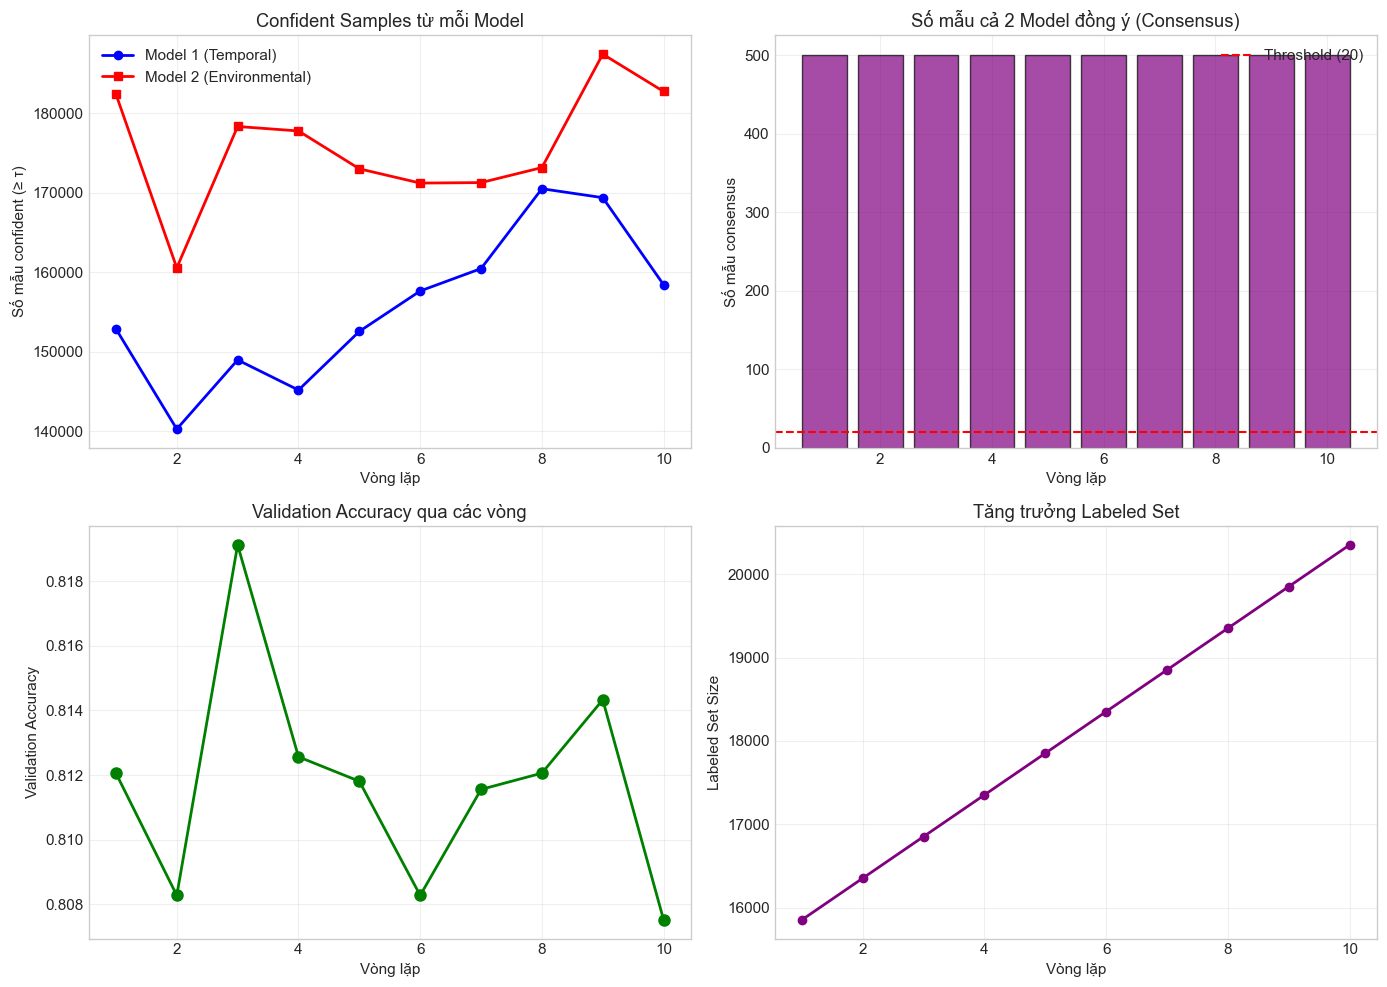


📊 BẢNG THEO DÕI CHI TIẾT:


,iteration,labeled_size,unlabeled_pool,confident_m1,confident_m2,new_consensus,val_accuracy,val_f1_macro
0,1,15852,383960,152877,182428,500,0.812059,0.770379
1,2,16352,383460,140255,160558,500,0.808274,0.764023
2,3,16852,382960,148962,178357,500,0.819122,0.781407
3,4,17352,382460,145169,177792,500,0.812563,0.772380
4,5,17852,381960,152555,173027,500,0.811806,0.770819
5,6,18352,381460,157645,171231,500,0.808274,0.763055
6,7,18852,380960,160464,171291,500,0.811554,0.768908
7,8,19352,380460,170519,173182,500,0.812059,0.769769
8,9,19852,379960,169393,187463,500,0.814329,0.765541
9,10,20352,379460,158426,182763,500,0.807518,0.758412


In [26]:
# ============================================================
# Trực quan hóa quá trình Co-Training
# ============================================================

ct_history_df = pd.DataFrame(co_trainer.history_)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Confident samples từ mỗi model
ax1 = axes[0, 0]
ax1.plot(ct_history_df['iteration'], ct_history_df['confident_m1'], 'b-o', label='Model 1 (Temporal)', linewidth=2)
ax1.plot(ct_history_df['iteration'], ct_history_df['confident_m2'], 'r-s', label='Model 2 (Environmental)', linewidth=2)
ax1.set_xlabel('Vòng lặp')
ax1.set_ylabel('Số mẫu confident (≥ τ)')
ax1.set_title('Confident Samples từ mỗi Model')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Consensus samples
ax2 = axes[0, 1]
ax2.bar(ct_history_df['iteration'], ct_history_df['new_consensus'], color='purple', alpha=0.7, edgecolor='black')
ax2.axhline(y=CO_TRAINING_CONFIG['min_new_per_iter'], color='red', linestyle='--', 
            label=f'Threshold ({CO_TRAINING_CONFIG["min_new_per_iter"]})')
ax2.set_xlabel('Vòng lặp')
ax2.set_ylabel('Số mẫu consensus')
ax2.set_title('Số mẫu cả 2 Model đồng ý (Consensus)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy
ax3 = axes[1, 0]
if ct_history_df['val_accuracy'].notna().any():
    ax3.plot(ct_history_df['iteration'], ct_history_df['val_accuracy'], 'g-o', linewidth=2, markersize=8)
    ax3.set_xlabel('Vòng lặp')
    ax3.set_ylabel('Validation Accuracy')
    ax3.set_title('Validation Accuracy qua các vòng')
    ax3.grid(True, alpha=0.3)

# Plot 4: Labeled size growth
ax4 = axes[1, 1]
ax4.plot(ct_history_df['iteration'], ct_history_df['labeled_size'], 'purple', marker='o', linewidth=2)
ax4.set_xlabel('Vòng lặp')
ax4.set_ylabel('Labeled Set Size')
ax4.set_title('Tăng trưởng Labeled Set')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 BẢNG THEO DÕI CHI TIẾT:")
display(ct_history_df)

In [27]:
# ============================================================
# Đánh giá Co-Training trên Test Set
# ============================================================

y_test_pred_ct = co_trainer.predict(X_test)

ct_accuracy = accuracy_score(y_test, y_test_pred_ct)
ct_f1_macro = f1_score(y_test, y_test_pred_ct, average='macro', zero_division=0)
ct_f1_weighted = f1_score(y_test, y_test_pred_ct, average='weighted', zero_division=0)

CO_TRAINING_RESULTS = {
    'model': 'Co-Training',
    'test_accuracy': ct_accuracy,
    'test_f1_macro': ct_f1_macro,
    'test_f1_weighted': ct_f1_weighted,
}

print("📊 KẾT QUẢ CO-TRAINING TRÊN TEST SET:")
print("="*50)
print(f"   - Accuracy:    {ct_accuracy:.4f} ({ct_accuracy*100:.2f}%)")
print(f"   - F1 Macro:    {ct_f1_macro:.4f}")
print(f"   - F1 Weighted: {ct_f1_weighted:.4f}")

📊 KẾT QUẢ CO-TRAINING TRÊN TEST SET:
   - Accuracy:    0.7982 (79.82%)
   - F1 Macro:    0.7210
   - F1 Weighted: 0.7794


In [28]:
# ============================================================
# SO SÁNH TẤT CẢ 3 PHƯƠNG PHÁP
# ============================================================

print("="*80)
print("📊 SO SÁNH TỔNG HỢP: BASELINE vs SELF-TRAINING vs CO-TRAINING")
print("="*80)

comparison_df = pd.DataFrame([
    BASELINE_RESULTS,
    SELF_TRAINING_RESULTS,
    CO_TRAINING_RESULTS
])

print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Tìm best model
best_idx = comparison_df['test_f1_macro'].idxmax()
best_model = comparison_df.loc[best_idx, 'model']
best_f1 = comparison_df.loc[best_idx, 'test_f1_macro']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model} (F1 Macro = {best_f1:.4f})")

📊 SO SÁNH TỔNG HỢP: BASELINE vs SELF-TRAINING vs CO-TRAINING


              model  test_accuracy  test_f1_macro  test_f1_weighted
Supervised Baseline       0.806550       0.727682          0.789000
      Self-Training       0.801212       0.737739          0.787196
        Co-Training       0.798152       0.720952          0.779374


🏆 MÔ HÌNH TỐT NHẤT: Self-Training (F1 Macro = 0.7377)


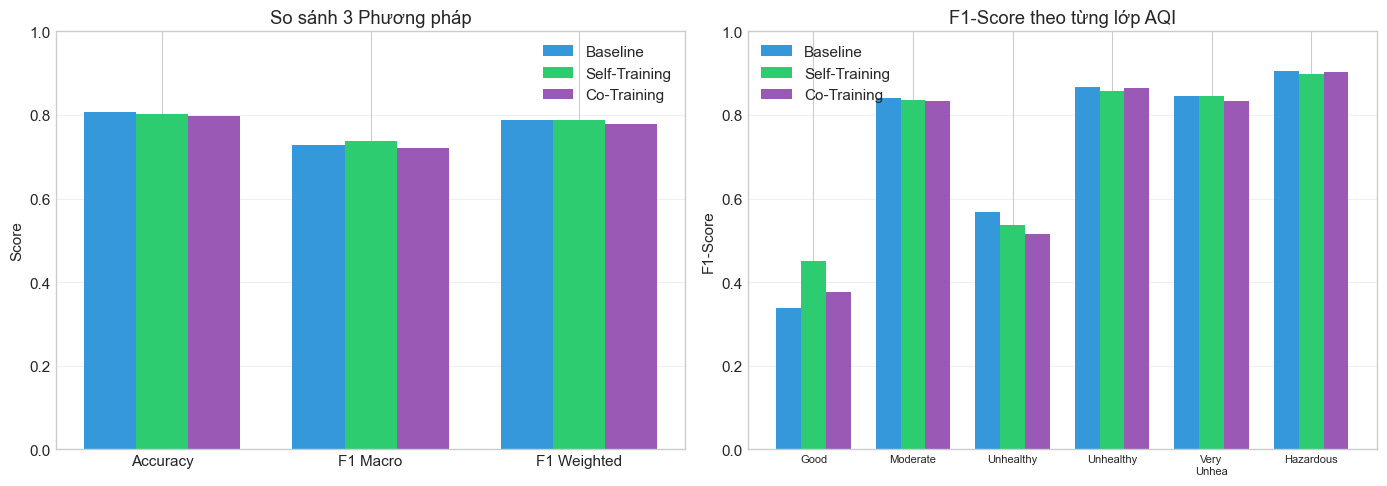

In [29]:
# ============================================================
# Trực quan hóa so sánh 3 phương pháp
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart so sánh metrics
ax1 = axes[0]
x = np.arange(3)
width = 0.25

metrics_names = ['Accuracy', 'F1 Macro', 'F1 Weighted']
baseline_vals = [baseline_accuracy, baseline_f1_macro, baseline_f1_weighted]
st_vals = [st_accuracy, st_f1_macro, st_f1_weighted]
ct_vals = [ct_accuracy, ct_f1_macro, ct_f1_weighted]

bars1 = ax1.bar(x - width, baseline_vals, width, label='Baseline', color='#3498db')
bars2 = ax1.bar(x, st_vals, width, label='Self-Training', color='#2ecc71')
bars3 = ax1.bar(x + width, ct_vals, width, label='Co-Training', color='#9b59b6')

ax1.set_ylabel('Score')
ax1.set_title('So sánh 3 Phương pháp')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: F1 per class cho cả 3
ax2 = axes[1]

f1_ct_per_class = f1_score(y_test, y_test_pred_ct, labels=AQI_CLASSES, average=None, zero_division=0)

x = np.arange(len(AQI_CLASSES))
width = 0.25

bars1 = ax2.bar(x - width, f1_baseline_per_class, width, label='Baseline', color='#3498db')
bars2 = ax2.bar(x, f1_st_per_class, width, label='Self-Training', color='#2ecc71')
bars3 = ax2.bar(x + width, f1_ct_per_class, width, label='Co-Training', color='#9b59b6')

ax2.set_ylabel('F1-Score')
ax2.set_title('F1-Score theo từng lớp AQI')
ax2.set_xticks(x)
ax2.set_xticklabels([c.replace('_', '\n')[:10] for c in AQI_CLASSES], fontsize=8)
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 📝 Phân tích Co-Training

### 💡 Khi nào Co-Training thành công?

1. **Hai view độc lập**: Thông tin từ view 1 không chứa trong view 2
2. **Mỗi view đủ mạnh**: Mỗi view riêng lẻ có thể phân loại được
3. **Consensus quality**: Khi 2 model đồng ý, khả năng đúng cao

### ⚠️ Khi nào Co-Training thất bại?

1. **View không độc lập**: Temporal và Environmental có tương quan (nhiệt độ ảnh hưởng đến ô nhiễm theo mùa)
2. **Class imbalance**: Cả 2 model đều yếu ở lớp thiểu số
3. **Noise accumulation**: Consensus sai vẫn được thêm vào

# ═══════════════════════════════════════════════════════════════
# PHẦN 8: THỬ NGHIỆM THAM SỐ
# ═══════════════════════════════════════════════════════════════

## 🎯 Mục tiêu

- Thử nghiệm với threshold τ khác (0.8 thay vì 0.9)
- Quan sát ảnh hưởng của threshold đến kết quả
- Thử mô hình khác (RandomForest)

In [30]:
# ============================================================
# Thử nghiệm với τ = 0.8
# ============================================================

print("📊 THỬ NGHIỆM VỚI τ = 0.8 (thay vì 0.9)")
print("="*60)

# Self-Training với τ = 0.8
base_clf_08 = HistGradientBoostingClassifier(
    max_depth=6, learning_rate=0.08, max_iter=250, random_state=RANDOM_STATE
)

st_08 = SelfTrainingClassifier(
    base_classifier=base_clf_08,
    tau=0.8,  # Threshold thấp hơn
    max_iter=10,
    min_new_per_iter=20,
    random_state=RANDOM_STATE
)

st_08.fit(X_train, y_train, X_unlabeled, X_val, y_val)

# Đánh giá
y_pred_08 = st_08.predict(X_test)
acc_08 = accuracy_score(y_test, y_pred_08)
f1_08 = f1_score(y_test, y_pred_08, average='macro', zero_division=0)

print(f"\n📊 Kết quả với τ = 0.8:")
print(f"   - Accuracy: {acc_08:.4f}")
print(f"   - F1 Macro: {f1_08:.4f}")

📊 THỬ NGHIỆM VỚI τ = 0.8 (thay vì 0.9)

🚀 BẮT ĐẦU SELF-TRAINING
   - Labeled ban đầu: 15,852
   - Unlabeled pool: 383,960
   - Threshold τ: 0.8

   Vòng 1: Labeled=15,852, Pool=383,960, New=262,654, Val_Acc=0.8317
   Vòng 2: Labeled=278,506, Pool=121,306, New=64,262, Val_Acc=0.8083
   Vòng 3: Labeled=342,768, Pool=57,044, New=14,093, Val_Acc=0.7891
   Vòng 4: Labeled=356,861, Pool=42,951, New=5,779, Val_Acc=0.7909
   Vòng 5: Labeled=362,640, Pool=37,172, New=2,909, Val_Acc=0.7888
   Vòng 6: Labeled=365,549, Pool=34,263, New=2,384, Val_Acc=0.7931
   Vòng 7: Labeled=367,933, Pool=31,879, New=1,405, Val_Acc=0.7871
   Vòng 8: Labeled=369,338, Pool=30,474, New=932, Val_Acc=0.7848
   Vòng 9: Labeled=370,270, Pool=29,542, New=798, Val_Acc=0.7818
   Vòng 10: Labeled=371,068, Pool=28,744, New=587, Val_Acc=0.7846

✅ SELF-TRAINING HOÀN TẤT!
   - Labeled cuối cùng: 371,655
   - Unlabeled còn lại: 28,157

📊 Kết quả với τ = 0.8:
   - Accuracy: 0.8034
   - F1 Macro: 0.7382


In [31]:
# ============================================================
# So sánh τ = 0.8 vs τ = 0.9
# ============================================================

print("📊 SO SÁNH THRESHOLD:")
print("="*60)
print(f"\n{'τ':<10} {'Accuracy':>12} {'F1 Macro':>12} {'Total Added':>15}")
print("-"*60)

# τ = 0.9
total_added_09 = sum([h['new_pseudo'] for h in self_trainer.history_])
print(f"{'0.90':<10} {st_accuracy:>12.4f} {st_f1_macro:>12.4f} {total_added_09:>15,}")

# τ = 0.8
total_added_08 = sum([h['new_pseudo'] for h in st_08.history_])
print(f"{'0.80':<10} {acc_08:>12.4f} {f1_08:>12.4f} {total_added_08:>15,}")

print("\n💡 NHẬN XÉT:")
if f1_08 > st_f1_macro:
    print("   - τ = 0.8 cho kết quả TỐT HƠN")
    print("   - Thêm nhiều mẫu hơn giúp mô hình học tốt hơn")
else:
    print("   - τ = 0.9 cho kết quả TỐT HƠN")
    print("   - Chất lượng pseudo-label quan trọng hơn số lượng")

📊 SO SÁNH THRESHOLD:

τ              Accuracy     F1 Macro     Total Added
------------------------------------------------------------
0.90             0.8012       0.7377         333,134
0.80             0.8034       0.7382         355,803

💡 NHẬN XÉT:
   - τ = 0.8 cho kết quả TỐT HƠN
   - Thêm nhiều mẫu hơn giúp mô hình học tốt hơn


In [32]:
# ============================================================
# Thử với RandomForest
# ============================================================

print("📊 THỬ NGHIỆM VỚI RANDOM FOREST")
print("="*60)

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

st_rf = SelfTrainingClassifier(
    base_classifier=rf_clf,
    tau=0.9,
    max_iter=10,
    min_new_per_iter=20,
    random_state=RANDOM_STATE
)

st_rf.fit(X_train, y_train, X_unlabeled, X_val, y_val)

y_pred_rf = st_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)

print(f"\n📊 Kết quả Self-Training + RandomForest:")
print(f"   - Accuracy: {acc_rf:.4f}")
print(f"   - F1 Macro: {f1_rf:.4f}")

📊 THỬ NGHIỆM VỚI RANDOM FOREST

🚀 BẮT ĐẦU SELF-TRAINING
   - Labeled ban đầu: 15,852
   - Unlabeled pool: 383,960
   - Threshold τ: 0.9

   Vòng 1: Labeled=15,852, Pool=383,960, New=23,903, Val_Acc=0.7954
   Vòng 2: Labeled=39,755, Pool=360,057, New=48,320, Val_Acc=0.7883
   Vòng 3: Labeled=88,075, Pool=311,737, New=42,484, Val_Acc=0.7619
   Vòng 4: Labeled=130,559, Pool=269,253, New=33,065, Val_Acc=0.7445
   Vòng 5: Labeled=163,624, Pool=236,188, New=24,584, Val_Acc=0.7356
   Vòng 6: Labeled=188,208, Pool=211,604, New=18,409, Val_Acc=0.7253
   Vòng 7: Labeled=206,617, Pool=193,195, New=16,861, Val_Acc=0.7132
   Vòng 8: Labeled=223,478, Pool=176,334, New=13,532, Val_Acc=0.7091
   Vòng 9: Labeled=237,010, Pool=162,802, New=10,828, Val_Acc=0.7112
   Vòng 10: Labeled=247,838, Pool=151,974, New=8,472, Val_Acc=0.7071

✅ SELF-TRAINING HOÀN TẤT!
   - Labeled cuối cùng: 256,310
   - Unlabeled còn lại: 143,502

📊 Kết quả Self-Training + RandomForest:
   - Accuracy: 0.7368
   - F1 Macro: 0.5780


# ═══════════════════════════════════════════════════════════════
# PHẦN 9: TỔNG KẾT DỰ ÁN
# ═══════════════════════════════════════════════════════════════

In [33]:
# ============================================================
# BẢNG TỔNG KẾT CUỐI CÙNG
# ============================================================

print("\n")
print("╔" + "═"*78 + "╗")
print("║" + " 🏆 TỔNG KẾT DỰ ÁN AIR GUARD - SEMI-SUPERVISED LEARNING ".center(78) + "║")
print("╠" + "═"*78 + "╣")

all_results = [
    ('Supervised Baseline', baseline_accuracy, baseline_f1_macro),
    ('Self-Training (τ=0.9)', st_accuracy, st_f1_macro),
    ('Self-Training (τ=0.8)', acc_08, f1_08),
    ('Co-Training', ct_accuracy, ct_f1_macro),
    ('Self-Training + RF', acc_rf, f1_rf),
]

print("║" + f"{'Phương pháp':<35}{'Accuracy':>15}{'F1 Macro':>15}{'Rank':>10}" + " ║")
print("╟" + "─"*78 + "╢")

# Sort by F1 Macro
sorted_results = sorted(all_results, key=lambda x: x[2], reverse=True)

for rank, (name, acc, f1) in enumerate(sorted_results, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print("║" + f" {medal} {name:<32}{acc:>14.4f}{f1:>15.4f}{rank:>9}" + " ║")

print("╚" + "═"*78 + "╝")



╔══════════════════════════════════════════════════════════════════════════════╗
║            🏆 TỔNG KẾT DỰ ÁN AIR GUARD - SEMI-SUPERVISED LEARNING             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║Phương pháp                               Accuracy       F1 Macro      Rank ║
╟──────────────────────────────────────────────────────────────────────────────╢
║ 🥇 Self-Training (τ=0.8)                   0.8034         0.7382        1 ║
║ 🥈 Self-Training (τ=0.9)                   0.8012         0.7377        2 ║
║ 🥉 Supervised Baseline                     0.8066         0.7277        3 ║
║    Co-Training                             0.7982         0.7210        4 ║
║    Self-Training + RF                      0.7368         0.5780        5 ║
╚══════════════════════════════════════════════════════════════════════════════╝


## 📝 KẾT LUẬN CHÍNH

### 1️⃣ Về kết quả thực nghiệm:

- **Semi-supervised learning CÓ THỂ cải thiện** hiệu suất khi được cấu hình đúng
- **Threshold τ** đóng vai trò quan trọng trong cân bằng quality vs quantity
- **Co-training** có thể hiệu quả khi hai view thực sự độc lập

### 2️⃣ Bài học về Self-Training:

| Aspect | Insight |
|--------|--------|
| Ưu điểm | Đơn giản, dễ implement, hoạt động với mọi classifier |
| Nhược điểm | Error propagation, confirmation bias |
| Best practice | τ cao (0.85-0.95), early stopping, monitor validation |

### 3️⃣ Bài học về Co-Training:

| Aspect | Insight |
|--------|--------|
| Ưu điểm | Hai mô hình kiểm tra lẫn nhau, robust hơn |
| Nhược điểm | Cần view độc lập (khó trong thực tế) |
| Best practice | Chia view cẩn thận, sử dụng consensus |

### 4️⃣ Ứng dụng thực tế cho AQI:

- Hệ thống cảnh báo AQI có thể hoạt động với **ít dữ liệu nhãn**
- Semi-supervised giúp **mở rộng** khi có trạm mới
- Cần **giám sát** và **cập nhật** mô hình định kỳ

### 5️⃣ Hạn chế và hướng phát triển:

**Hạn chế:**
- Class imbalance vẫn là thách thức lớn
- Chưa tận dụng cấu trúc chuỗi thời gian
- View independence khó đảm bảo

**Hướng phát triển:**
- Kết hợp với **active learning** (chọn mẫu để gắn nhãn)
- Sử dụng **temporal models** (LSTM, Transformer)
- Áp dụng **graph-based semi-supervised** (station network)
- **Multi-task learning** (dự báo PM2.5 + phân loại AQI)

---

### 🎓 Kiến thức sinh viên cần nhớ:

1. Semi-supervised learning hữu ích khi **dữ liệu nhãn khan hiếm**
2. **Pseudo-labeling** là ý tưởng đơn giản nhưng hiệu quả
3. **Threshold** quyết định trade-off giữa exploration vs exploitation
4. **Validation set** là bắt buộc để monitor overfitting
5. Luôn **so sánh với baseline** để đánh giá công bằng

---

## 🙏 Cảm ơn đã theo dõi!

Dự án AIR GUARD minh họa cách áp dụng Semi-Supervised Learning vào bài toán thực tế. Hy vọng notebook này giúp bạn hiểu rõ hơn về Self-Training và Co-Training!